https://github.com/altdeep/causalAI/blob/master/book/chapter%2011/Chapter_11_Bayesian_Causal_Graphical_Inference.ipynb

In [1]:
import arviz as az
import graphviz as gr
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import numpyro
import numpyro.distributions as dist
import optax
import polars as pl
from flax import nnx
from jax import random
from numpyro.contrib.module import nnx_module
from numpyro.handlers import condition, do
from numpyro.infer import SVI, Predictive, Trace_ELBO

numpyro.set_host_device_count(n=10)

rng_key = random.PRNGKey(seed=42)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%load_ext jaxtyping
%jaxtyping.typechecker beartype.beartype
%config InlineBackend.figure_format = "retina"

In [2]:
data_path = "https://raw.githubusercontent.com/altdeep/causalML/master/datasets/online_game_ate.csv"

raw_df = pl.read_csv(data_path)


columns_to_keep = [
    "Guild Membership",
    "Side-quest Engagement",
    "Won Items",
    "In-game Purchases",
]

df = raw_df[columns_to_keep]

df.head()

Guild Membership,Side-quest Engagement,Won Items,In-game Purchases
i64,i64,i64,f64
0,1,1,1030.29
0,1,0,2453.34
0,1,1,3761.4
1,1,1,1007.84
0,1,0,4153.94


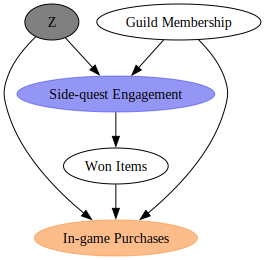

In [3]:
g = gr.Digraph()

g.node("Side-quest Engagement", color="#2a2eec80", style="filled")
g.node("In-game Purchases", color="#fa7c1780", style="filled")

g.node("Z", style="filled", fillcolor="gray")

g.edge("Side-quest Engagement", "Won Items")
g.edge("Won Items", "In-game Purchases")
g.edge("Guild Membership", "Side-quest Engagement")
g.edge("Guild Membership", "In-game Purchases")

g.edge("Z", "Side-quest Engagement")
g.edge("Z", "In-game Purchases")

g

In [4]:
# Convert graphviz graph to networkx
g_nx = nx.DiGraph()

# Extract edges from graphviz graph
for edge in g.body:
    if "->" in edge:
        # Parse edge string (format: "node1 -> node2")
        parts = edge.strip().split("->")
        source = parts[0].strip().strip('"')
        target = parts[1].strip().strip('"')
        g_nx.add_edge(source, target)

/Users/juan.orduz/Documents/website_projects/.pixi/envs/default/lib/python3.13/site-packages/dowhy/causal_model.py:581: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


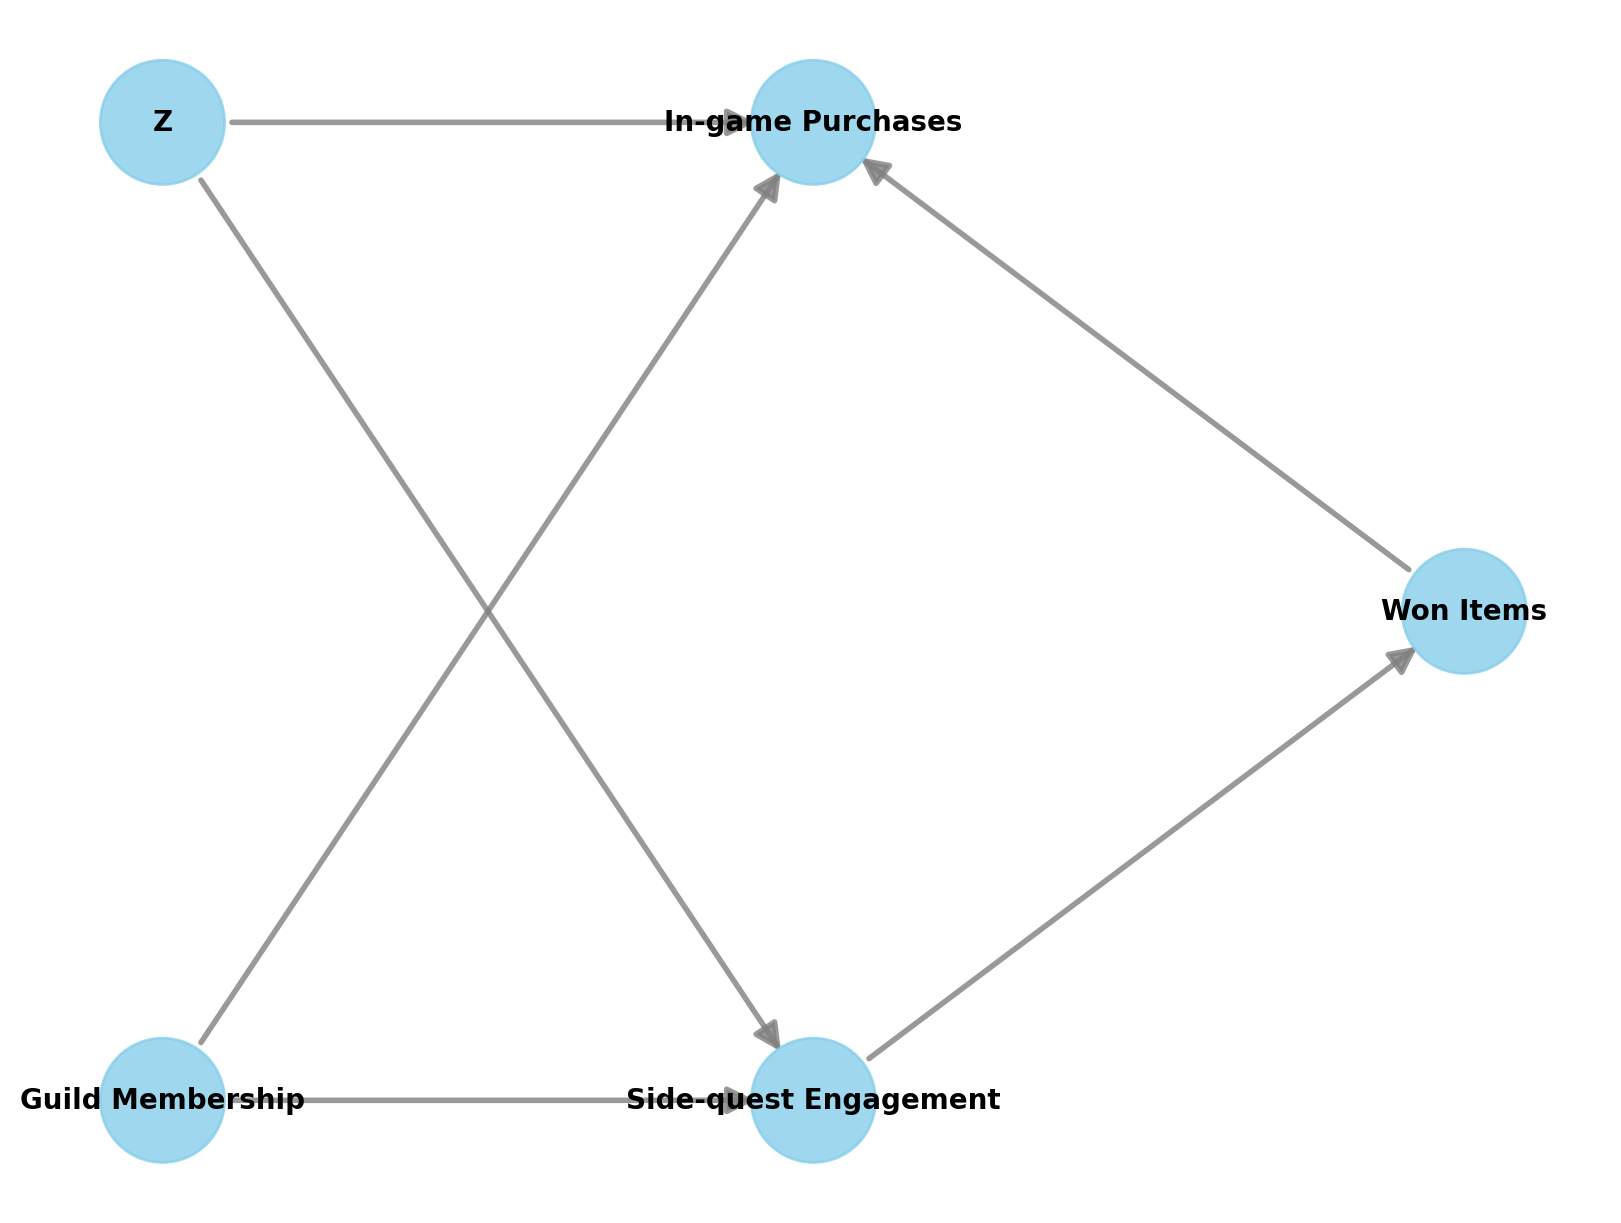

In [5]:
from dowhy import CausalModel

model = CausalModel(
    data=df.to_pandas(),
    graph=g_nx,
    treatment="Side-quest Engagement",
    outcome="In-game Purchases",
)

model.view_model()

In [6]:
estimand = model.identify_effect()

print(estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
 ⎡     d                                     d                         ⎤
E⎢────────────(In-game Purchases)⋅────────────────────────([Won Items])⎥
 ⎣d[Won Items]                    d[Side-quest Engagement]             ⎦
Estimand assumption 1, Full-mediation: Won Items intercepts (blocks) all directed paths from Side-quest Engagement to I,n,-,g,a,m,e, ,P,u,r,c,h,a,s,e,s.
Estimand assumption 2, First-stage-unconfoundedness: If U→{Side-quest Engagement} and U→{Won Items} then P(Won Items|Side-quest Engagement,U) = P(Won Items|Side-quest Engagement)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{Won Items} and U→In-game Purchases then P(In-game Purchases|Won Items, Side-quest Engagement, U) = P(In-game Purchases|Won Items, Side-quest Engage

In [7]:
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name="frontdoor.two_stage_regression",
    target_units="ate",
    method_params={"weighting_scheme": "ips_weight"},
    test_significance=True,
    confidence_intervals=True,
)

estimate_value = estimate.value
estimate_ci = estimate.get_confidence_intervals()

print(f"Estimate of causal effect (linear regression): {estimate_value}")
print(f"confidence interval: {estimate_ci}")

Estimate of causal effect (linear regression): 170.2056058128939
confidence interval: (np.float64(129.7703928324415), np.float64(204.61976557874107))


In [8]:
is_guild_member = df["Guild Membership"].to_jax()
is_highly_engaged = df["Side-quest Engagement"].to_jax()
won_items = df["Won Items"].to_jax()
in_game_purchases = df["In-game Purchases"].to_jax()

In [9]:
class Confounders2Engagement(nnx.Module):
    def __init__(
        self,
        input_dim: int = 2,
        output_dim: int = 1,
        hidden_dim: int = 5,
        *,
        rngs: nnx.Rngs,
    ) -> None:
        self.fc1 = nnx.Linear(input_dim, hidden_dim, rngs=rngs)
        self.f_engagement_ρ = nnx.Linear(hidden_dim, 1, rngs=rngs)

    def __call__(self, x: jax.Array) -> jax.Array:
        hidden = jax.nn.softplus(self.fc1(x))
        ρ_engagement = jax.nn.sigmoid(self.f_engagement_ρ(hidden))
        return ρ_engagement.T.squeeze(0)


class PurchasesNetwork(nnx.Module):
    def __init__(
        self,
        input_dim=3,
        hidden_dim=5,
        *,
        rngs: nnx.Rngs,
    ):
        super().__init__()
        self.f_hidden = nnx.Linear(input_dim, hidden_dim, rngs=rngs)
        self.f_purchase_μ = nnx.Linear(hidden_dim, 1, rngs=rngs)
        self.f_purchase_σ = nnx.Linear(hidden_dim, 1, rngs=rngs)

    def __call__(self, x: jax.Array) -> tuple[jax.Array, jax.Array]:
        hidden = jax.nn.softplus(self.f_hidden(x))
        μ_purchases = self.f_purchase_μ(hidden)
        σ_purchases = 1e-6 + jax.nn.softplus(self.f_purchase_σ(hidden))
        μ_purchases = μ_purchases.T.squeeze(0)
        σ_purchases = σ_purchases.T.squeeze(0)
        return μ_purchases, σ_purchases

In [10]:
rng_key, rng_subkey = random.split(rng_key)
nn_confounders_2_engagement = Confounders2Engagement(rngs=nnx.Rngs(rng_subkey))

rng_key, rng_subkey = random.split(rng_key)
nn_purchases_network = PurchasesNetwork(rngs=nnx.Rngs(rng_subkey))

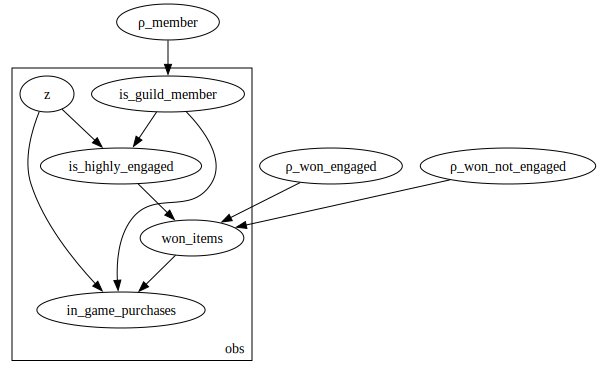

In [11]:
def model(is_guild_member, is_highly_engaged, won_items, in_game_purchases):
    n_obs = is_guild_member.shape[0]

    ρ_member = numpyro.sample("ρ_member", dist.Beta(2, 5))

    ρ_won_engaged = numpyro.sample("ρ_won_engaged", dist.Beta(5, 2))
    ρ_won_not_engaged = numpyro.sample("ρ_won_not_engaged", dist.Beta(2, 5))

    with numpyro.plate("obs", n_obs):
        z = numpyro.sample("z", dist.Normal(0.0, 1.0))

        is_guild_member = numpyro.sample("is_guild_member", dist.Bernoulli(ρ_member))

        engagement_input = jnp.stack((is_guild_member, z)).T

        nnx_confounders_2_engagement = nnx_module(
            "nnx_confounders_2_engagement", nn_confounders_2_engagement
        )

        ρ_engagement = nnx_confounders_2_engagement(engagement_input)

        is_highly_engaged = numpyro.sample(
            "is_highly_engaged",
            dist.Bernoulli(ρ_engagement),
        )

        p_won = ρ_won_engaged * is_highly_engaged + ρ_won_not_engaged * (
            1 - is_highly_engaged
        )

        won_items = numpyro.sample("won_items", dist.Bernoulli(p_won))

        purchase_input = jnp.stack((won_items, is_guild_member, z)).T

        nnx_purchases_network = nnx_module(
            "nnx_purchases_network", nn_purchases_network
        )
        μ_purchases, σ_purchases = nnx_purchases_network(purchase_input)
        numpyro.sample("in_game_purchases", dist.Normal(μ_purchases, σ_purchases))


numpyro.render_model(
    model,
    model_kwargs={
        "is_guild_member": is_guild_member,
        "is_highly_engaged": is_highly_engaged,
        "won_items": won_items,
        "in_game_purchases": in_game_purchases,
    },
)

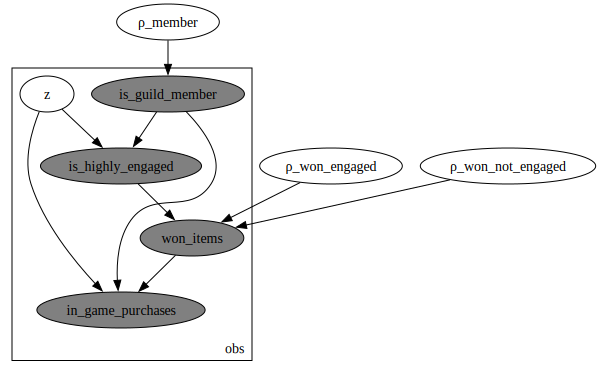

In [12]:
conditioned_model = condition(
    model,
    data={
        "is_guild_member": is_guild_member,
        "is_highly_engaged": is_highly_engaged,
        "won_items": won_items,
        "in_game_purchases": in_game_purchases,
    },
)

numpyro.render_model(
    conditioned_model,
    model_kwargs={
        "is_guild_member": is_guild_member,
        "is_highly_engaged": is_highly_engaged,
        "won_items": won_items,
        "in_game_purchases": in_game_purchases,
    },
)

In [13]:
class Encoder(nnx.Module):
    def __init__(
        self,
        input_dim=3,
        z_dim=1,
        hidden_dim=5,
        *,
        rngs: nnx.Rngs,
    ):
        super().__init__()
        self.f_hidden = nnx.Linear(input_dim, hidden_dim, rngs=rngs)
        self.f_loc = nnx.Linear(hidden_dim, z_dim, rngs=rngs)
        self.f_scale = nnx.Linear(hidden_dim, z_dim, rngs=rngs)

    def __call__(self, x: jax.Array) -> tuple[jax.Array, jax.Array]:
        x = x.T
        hidden = jax.nn.softplus(self.f_hidden(x))
        z_loc = self.f_loc(hidden)
        z_scale = 1e-6 + jax.nn.softplus(self.f_scale(hidden))
        return z_loc.T.squeeze(0), z_scale.T.squeeze(0)


rng_key, rng_subkey = random.split(rng_key)
nn_encoder = Encoder(rngs=nnx.Rngs(rng_subkey))

In [14]:
def guide(is_guild_member, is_highly_engaged, won_items, in_game_purchases):
    α_member = numpyro.param("α_member", jnp.array(1.0))
    β_member = numpyro.param("β_member", jnp.array(1.0))
    numpyro.sample("ρ_member", dist.Beta(α_member, β_member))

    α_won_engaged = numpyro.param(
        "α_won_engaged", jnp.array(5.0), constraint=dist.constraints.positive
    )
    β_won_engaged = numpyro.param(
        "β_won_engaged", jnp.array(2.0), constraint=dist.constraints.positive
    )
    numpyro.sample("ρ_won_engaged", dist.Beta(α_won_engaged, β_won_engaged))
    α_won_not_engaged = numpyro.param(
        "α_won_not_engaged", jnp.array(2.0), constraint=dist.constraints.positive
    )
    β_won_not_engaged = numpyro.param(
        "β_won_not_engaged", jnp.array(5.0), constraint=dist.constraints.positive
    )
    beta_dist = dist.Beta(α_won_not_engaged, β_won_not_engaged)
    numpyro.sample("ρ_won_not_engaged", beta_dist)

    n_obs = is_guild_member.shape[0]

    nnx_encoder = nnx_module("nnx_encoder", nn_encoder)

    with numpyro.plate("obs", n_obs):
        z_input = jnp.stack((is_guild_member, is_highly_engaged, in_game_purchases))
        z_loc, z_scale = nnx_encoder(z_input)
        numpyro.sample("z", dist.Normal(z_loc, z_scale))

100%|██████████| 120000/120000 [02:25<00:00, 825.50it/s, init loss: 14015630336.0000, avg. loss [114001-120000]: 120582.7422]


CPU times: user 3min 46s, sys: 47.5 s, total: 4min 33s
Wall time: 2min 30s


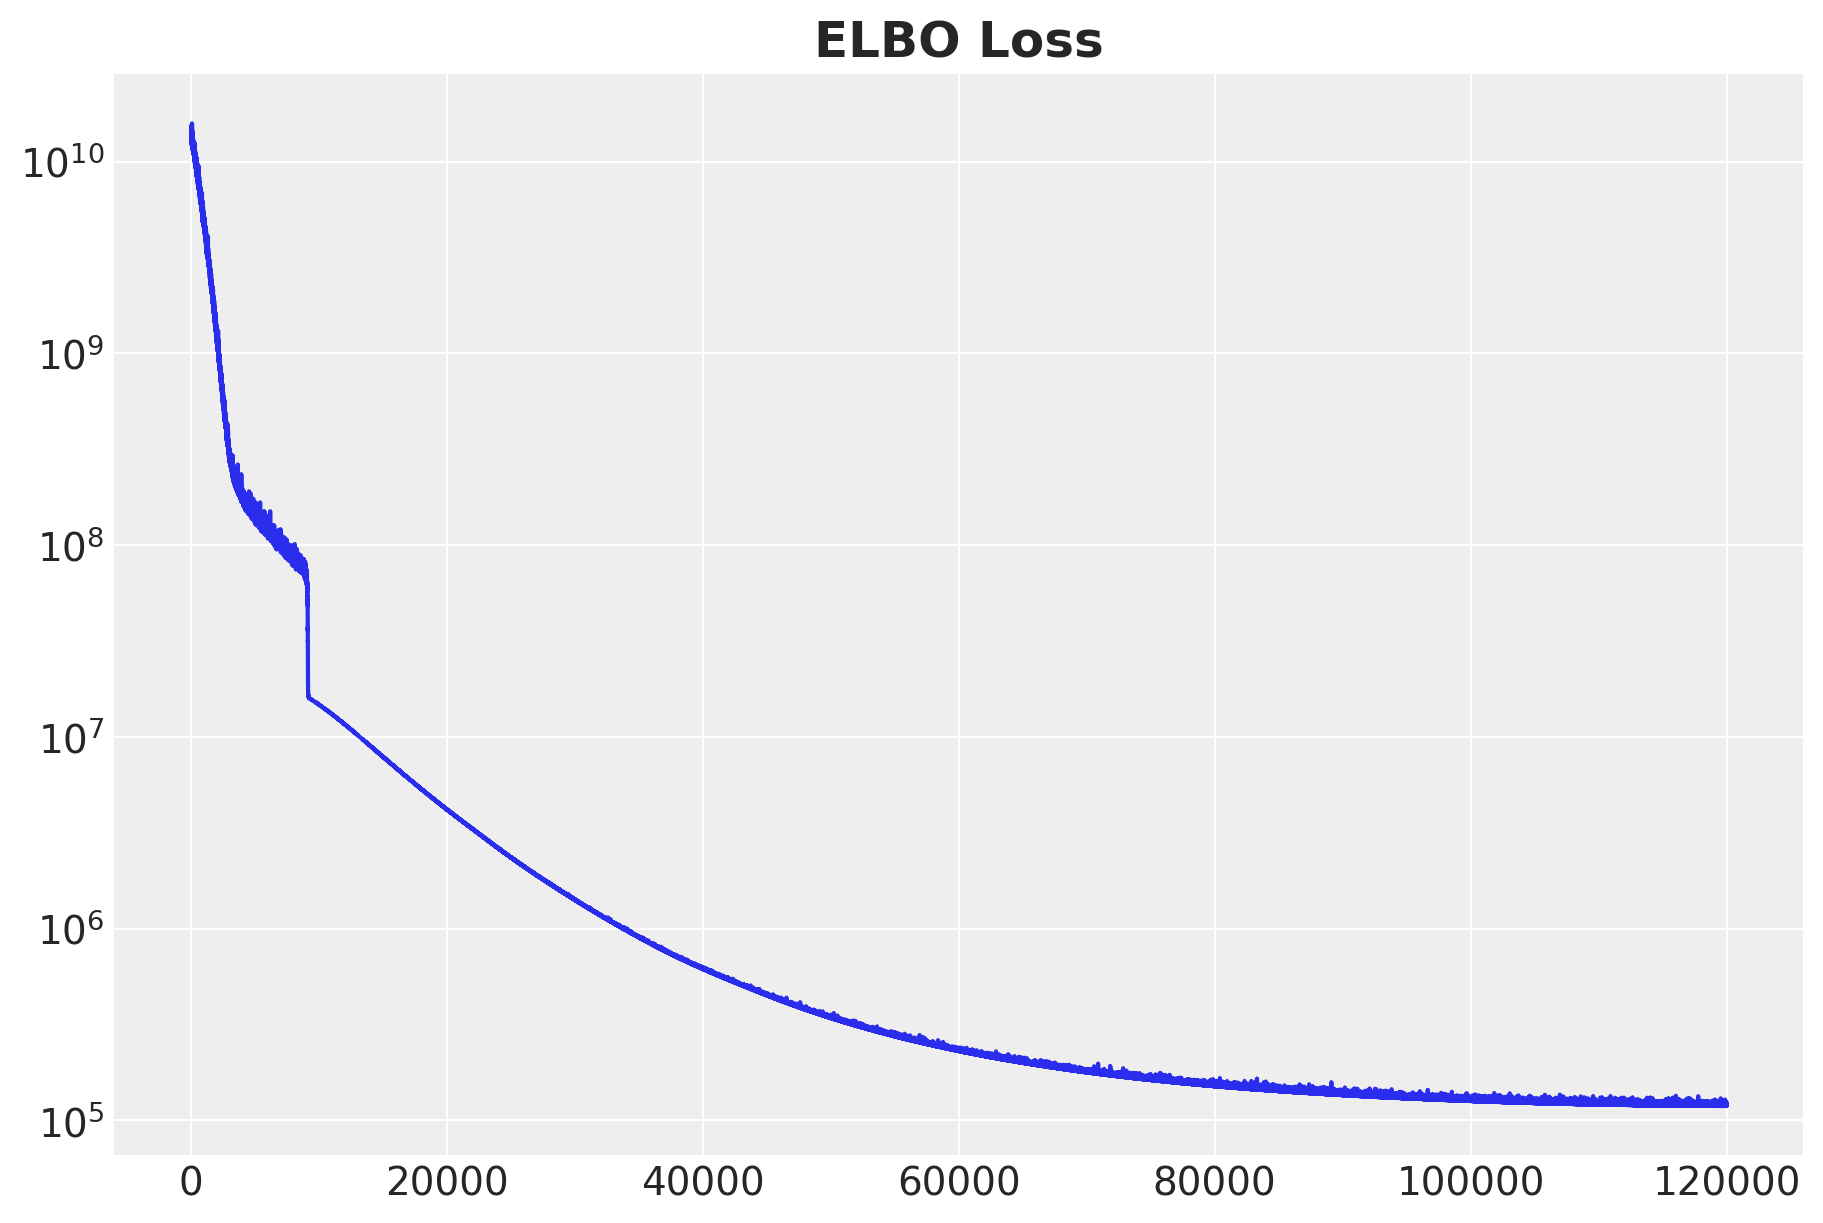

In [15]:
%%time

n_samples = 120_000
scheduler = optax.linear_onecycle_schedule(
    transition_steps=n_samples,
    peak_value=0.0001,
    pct_start=0.3,
    pct_final=0.85,
    div_factor=2,
    final_div_factor=5,
)

optimizer = optax.chain(
    optax.adam(learning_rate=scheduler),
    optax.contrib.reduce_on_plateau(
        factor=0.8,
        patience=20,
        accumulation_size=100,
    ),
)

svi = SVI(conditioned_model, guide, optimizer, loss=Trace_ELBO())
rng_key, rng_subkey = random.split(key=rng_key)
svi_result = svi.run(
    rng_subkey,
    n_samples,
    is_guild_member=is_guild_member,
    is_highly_engaged=is_highly_engaged,
    won_items=won_items,
    in_game_purchases=in_game_purchases,
)

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(svi_result.losses)
ax.set(yscale="log")
ax.set_title("ELBO Loss", fontsize=18, fontweight="bold");

In [16]:
params = svi_result.params

posterior_predictive = Predictive(
    model=model,
    guide=guide,
    params=params,
    num_samples=2_000,
    return_sites=[
        "in_game_purchases",
    ],
)
rng_key, rng_subkey = random.split(key=rng_key)
posterior_predictive_samples = posterior_predictive(
    rng_subkey,
    is_guild_member,
    is_highly_engaged,
    won_items,
    in_game_purchases,
)

idata = az.from_dict(
    posterior_predictive={
        k: np.expand_dims(a=np.asarray(v), axis=0)
        for k, v in posterior_predictive_samples.items()
    },
    observed_data={
        "in_game_purchases": in_game_purchases,
    },
    coords={"obs_idx": range(df.shape[0])},
    dims={
        "in_game_purchases": ["obs_idx"],
    },
)

<Axes: xlabel='in_game_purchases'>

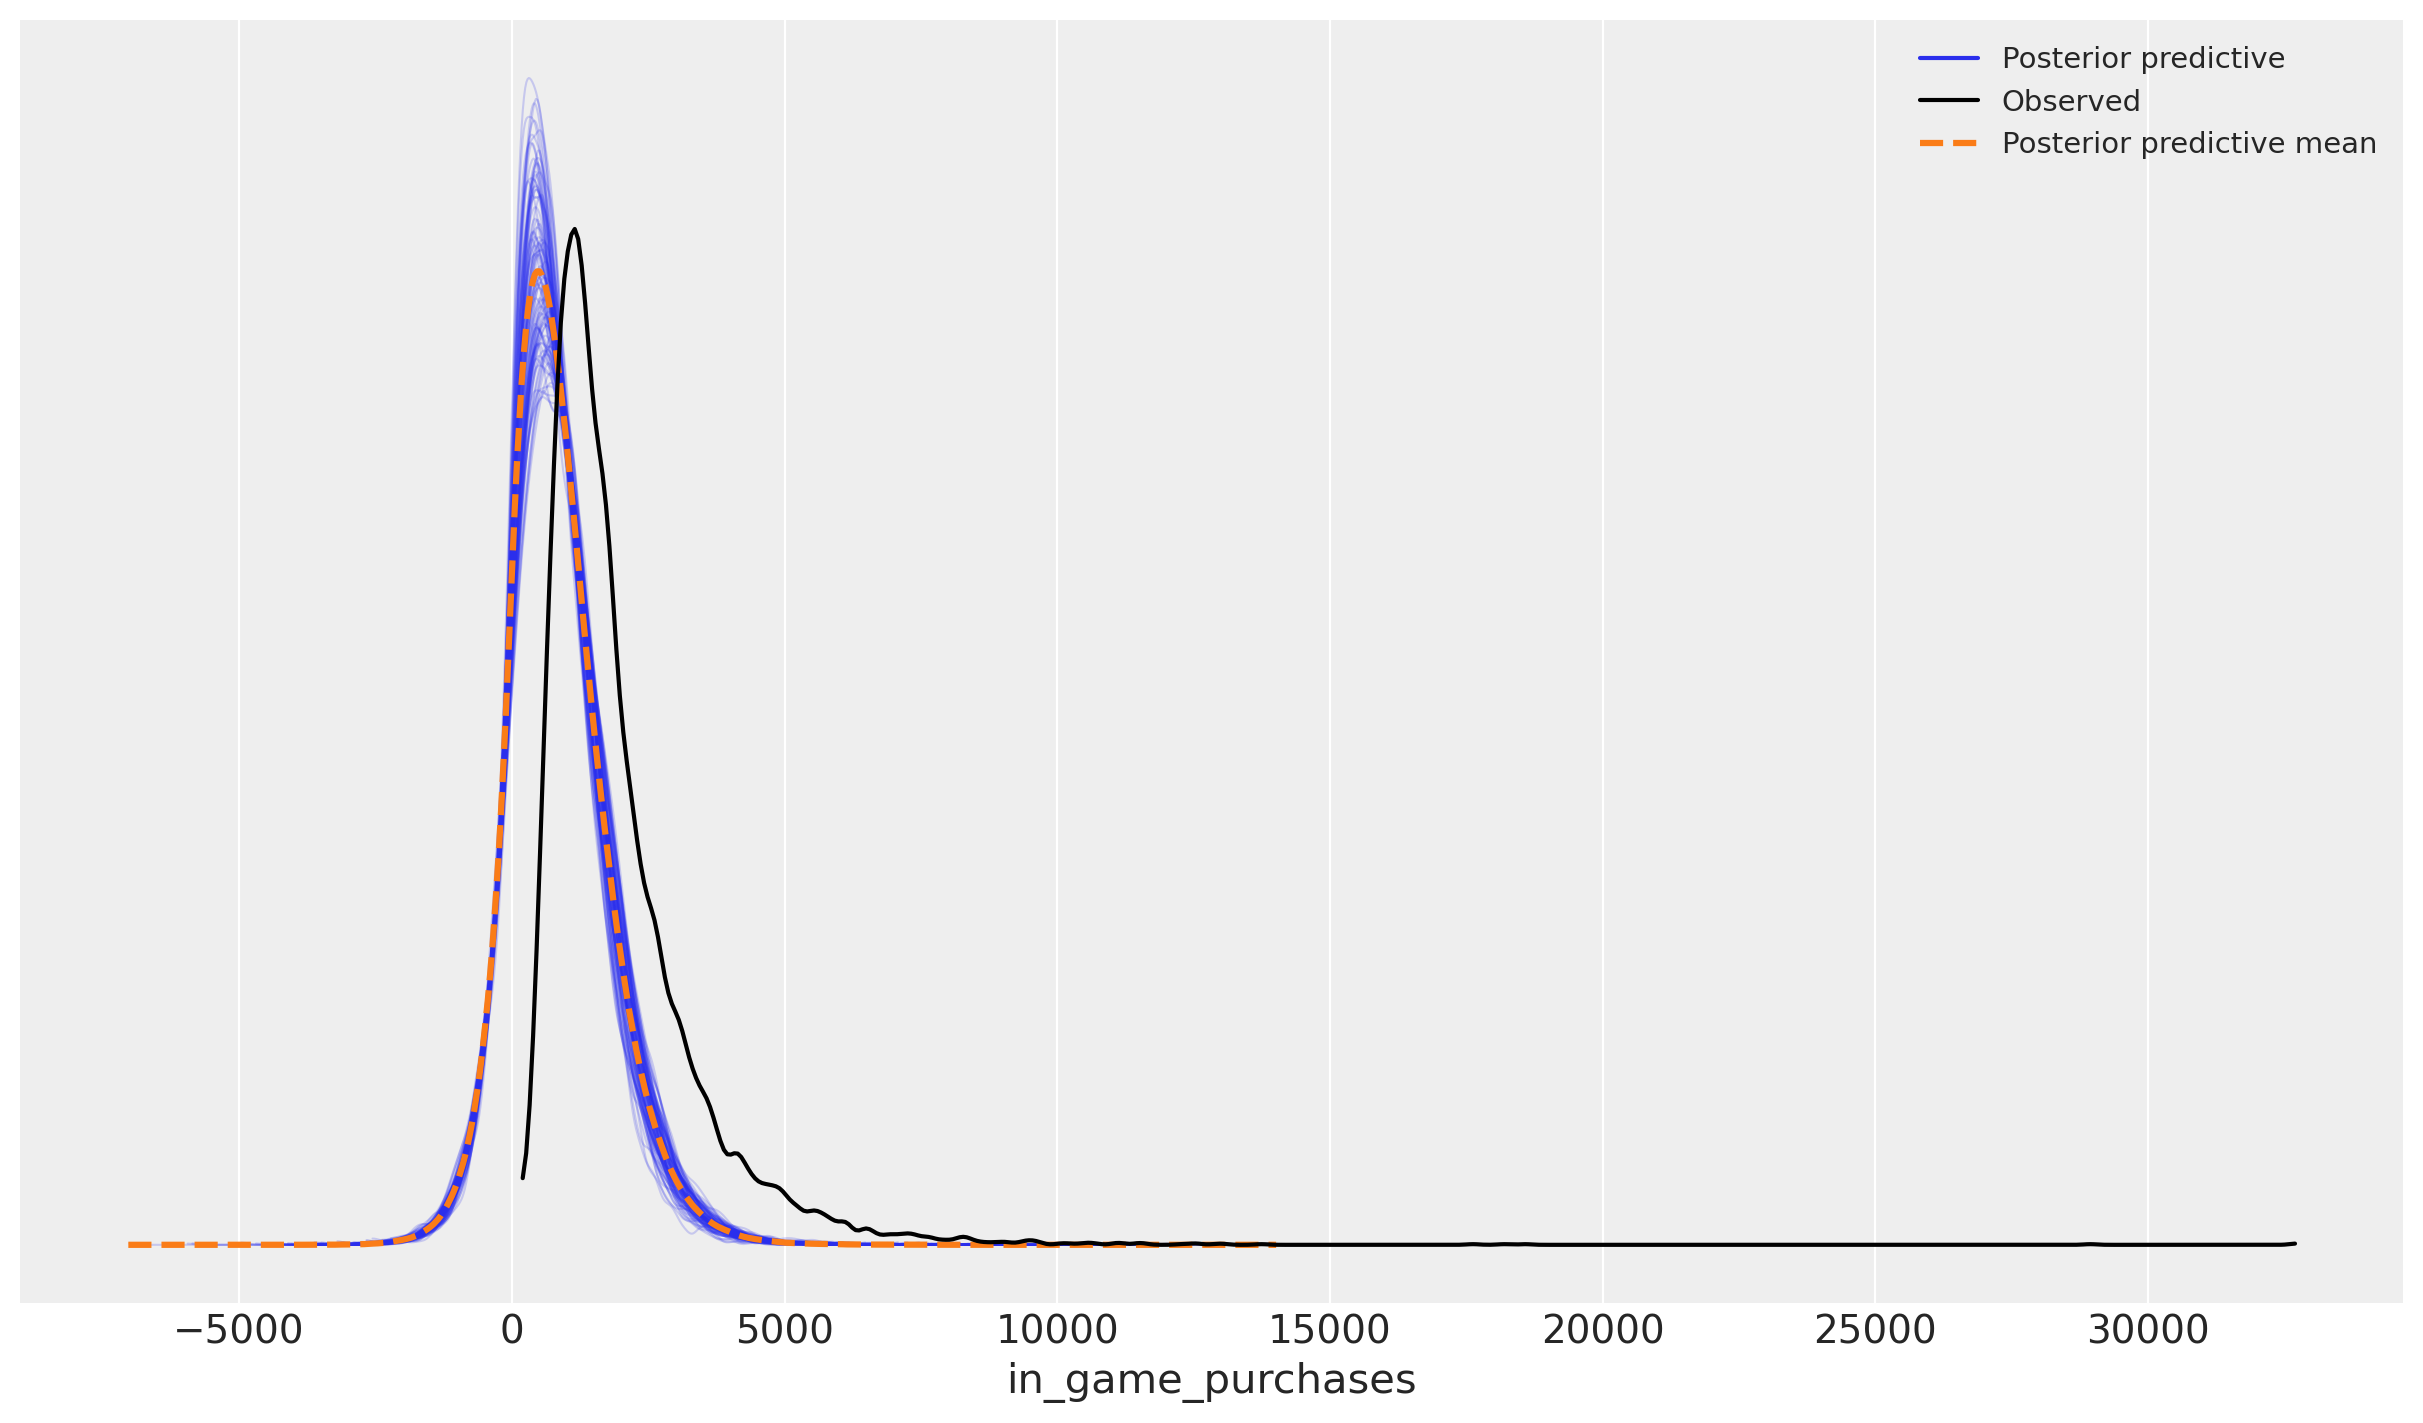

In [17]:
az.plot_ppc(idata, num_pp_samples=100, group="posterior")

In [18]:
do_0_model = do(model, data={"is_highly_engaged": 0})
do_0_posterior_predictive = Predictive(
    model=do_0_model,
    guide=guide,
    params=params,
    num_samples=2_000,
    return_sites=[
        "in_game_purchases",
    ],
)
rng_key, rng_subkey = random.split(rng_key)
do_0_posterior_predictive_samples = do_0_posterior_predictive(
    rng_subkey,
    is_guild_member,
    is_highly_engaged,
    won_items,
    in_game_purchases,
)
do_0_idata = az.from_dict(
    posterior_predictive={
        k: np.expand_dims(a=np.asarray(v), axis=0)
        for k, v in do_0_posterior_predictive_samples.items()
    },
    observed_data={
        "in_game_purchases": in_game_purchases,
    },
    coords={"obs_idx": range(df.shape[0])},
    dims={
        "in_game_purchases": ["obs_idx"],
    },
)

do_1_model = do(model, data={"is_highly_engaged": 1})
do_1_posterior_predictive = Predictive(
    model=do_1_model,
    guide=guide,
    params=params,
    num_samples=2_000,
    return_sites=[
        "in_game_purchases",
    ],
)

rng_key, rng_subkey = random.split(rng_key)
do_1_posterior_predictive_samples = do_1_posterior_predictive(
    rng_subkey,
    is_guild_member,
    is_highly_engaged,
    won_items,
    in_game_purchases,
)
do_1_idata = az.from_dict(
    posterior_predictive={
        k: np.expand_dims(a=np.asarray(v), axis=0)
        for k, v in do_1_posterior_predictive_samples.items()
    },
    observed_data={
        "in_game_purchases": in_game_purchases,
    },
    coords={"obs_idx": range(df.shape[0])},
    dims={
        "in_game_purchases": ["obs_idx"],
    },
)

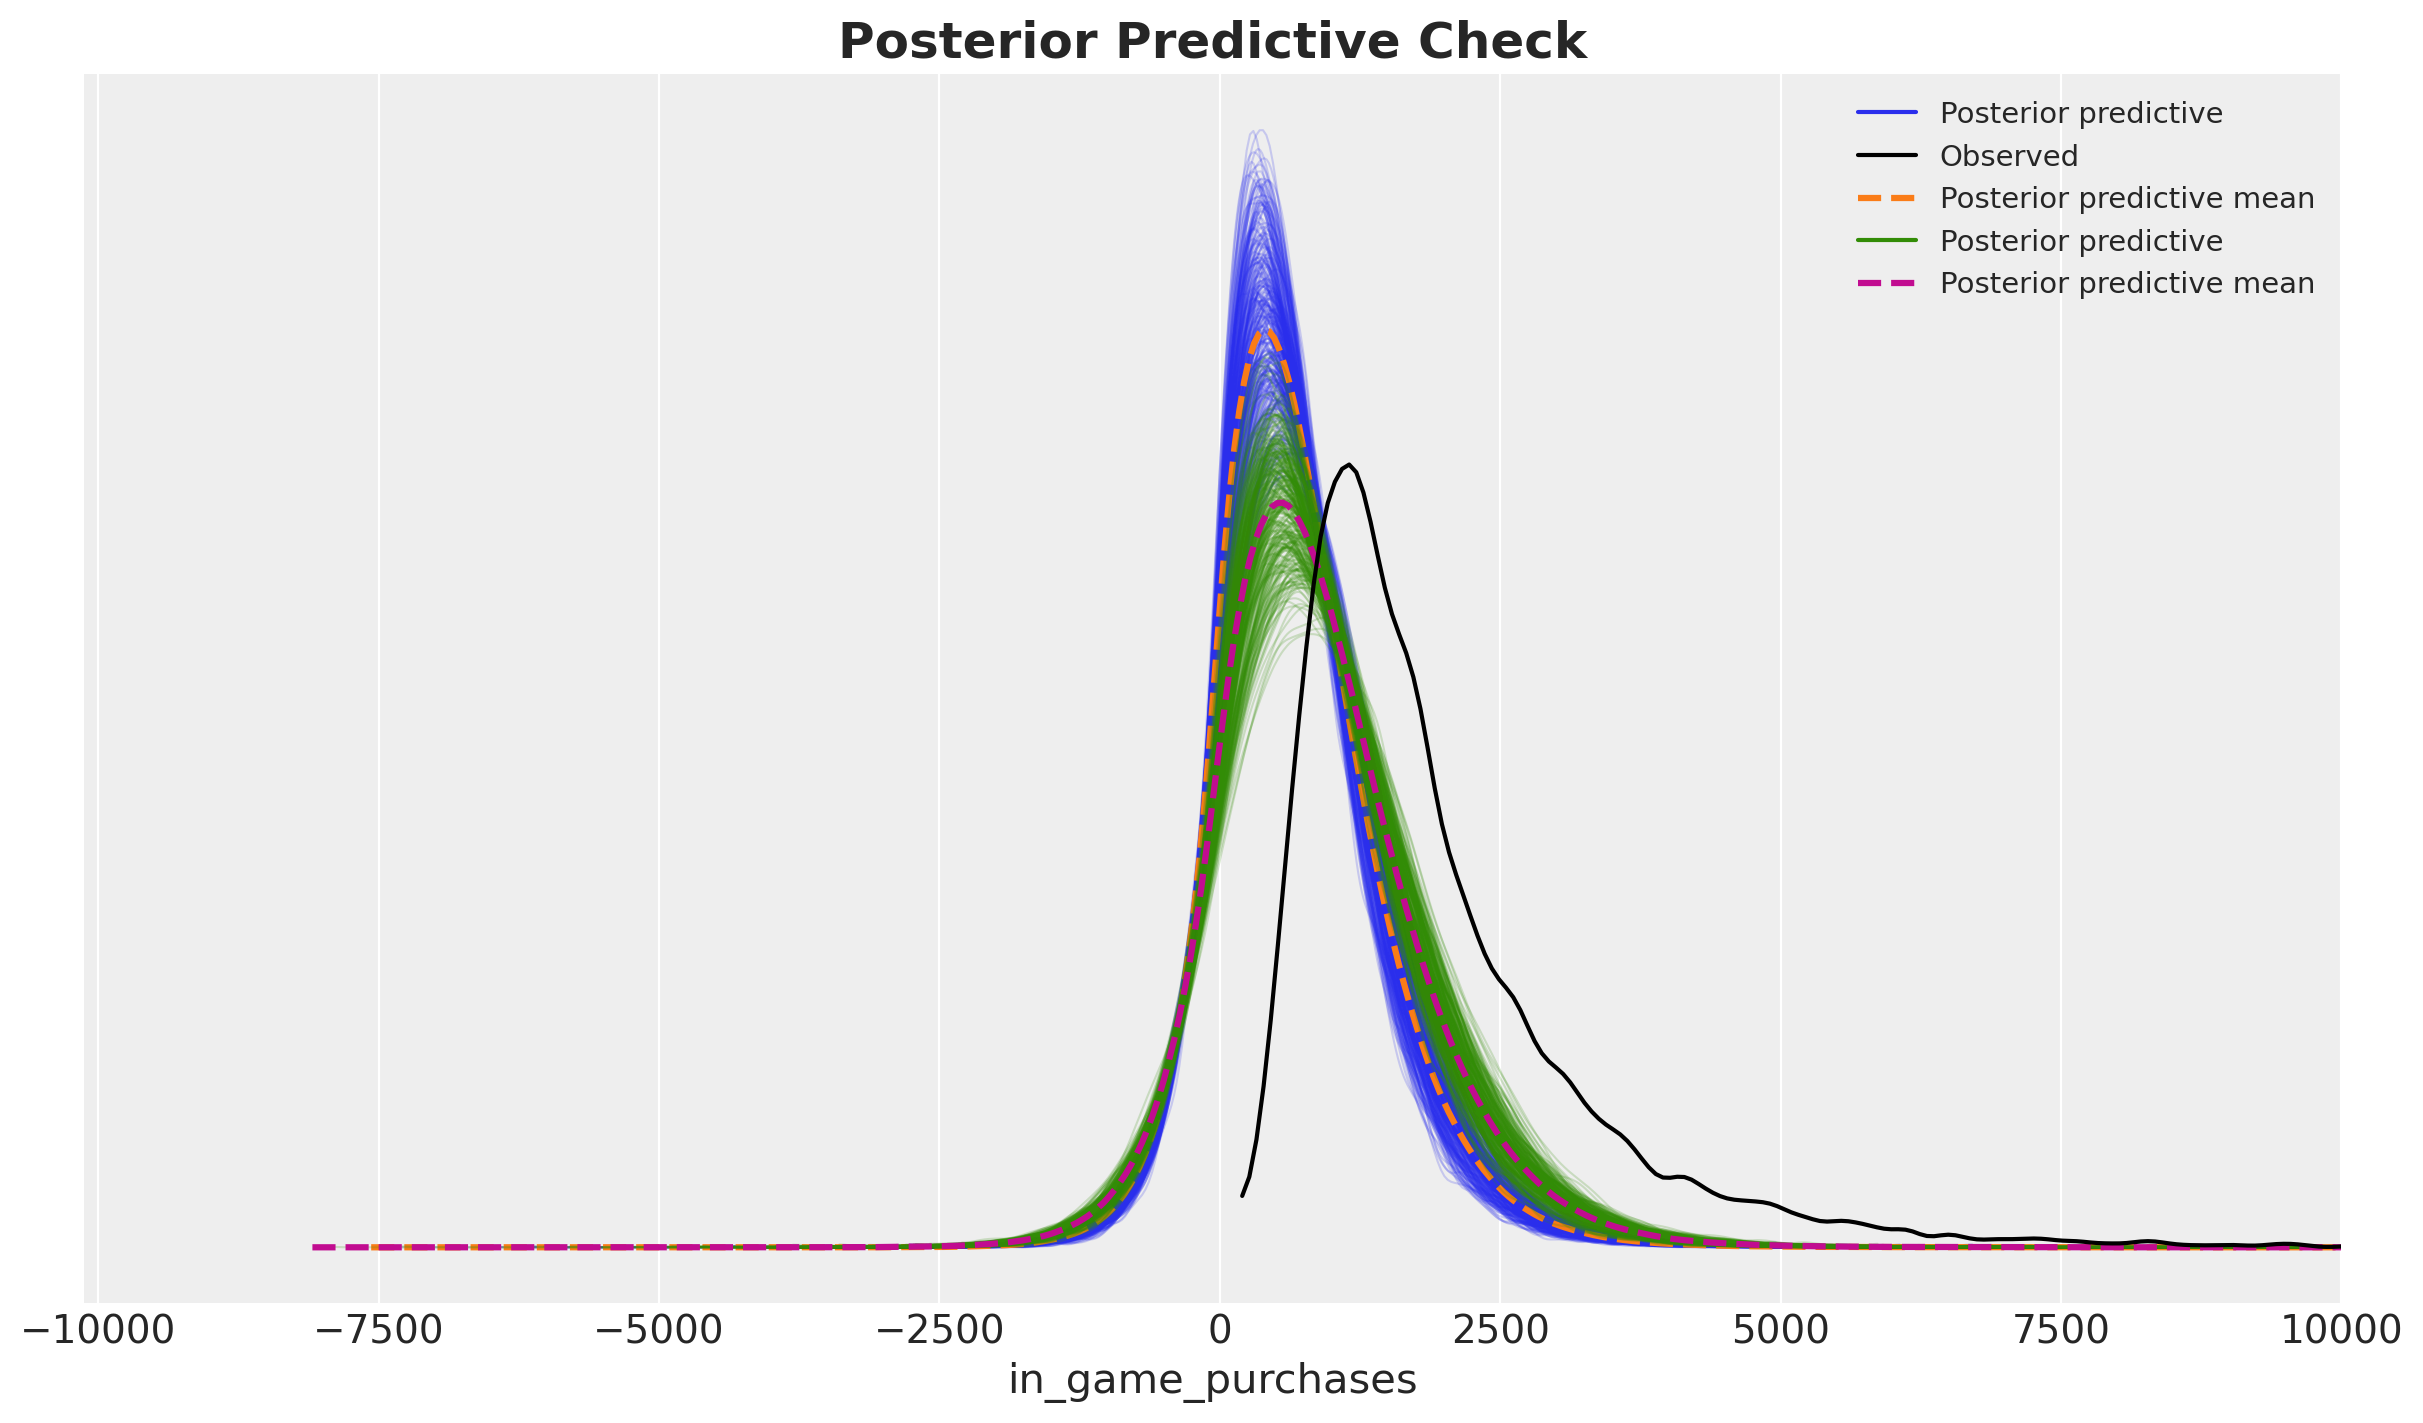

In [19]:
num_pp_samples = 300

fig, ax = plt.subplots()
az.plot_ppc(
    do_0_idata,
    num_pp_samples=num_pp_samples,
    group="posterior",
    ax=ax,
)
az.plot_ppc(
    do_1_idata,
    num_pp_samples=num_pp_samples,
    group="posterior",
    observed=False,
    colors=["C2", "k", "C3"],
    ax=ax,
)
ax.set(xlim=(None, 10_000))
ax.set_title("Posterior Predictive Check", fontsize=18, fontweight="bold");

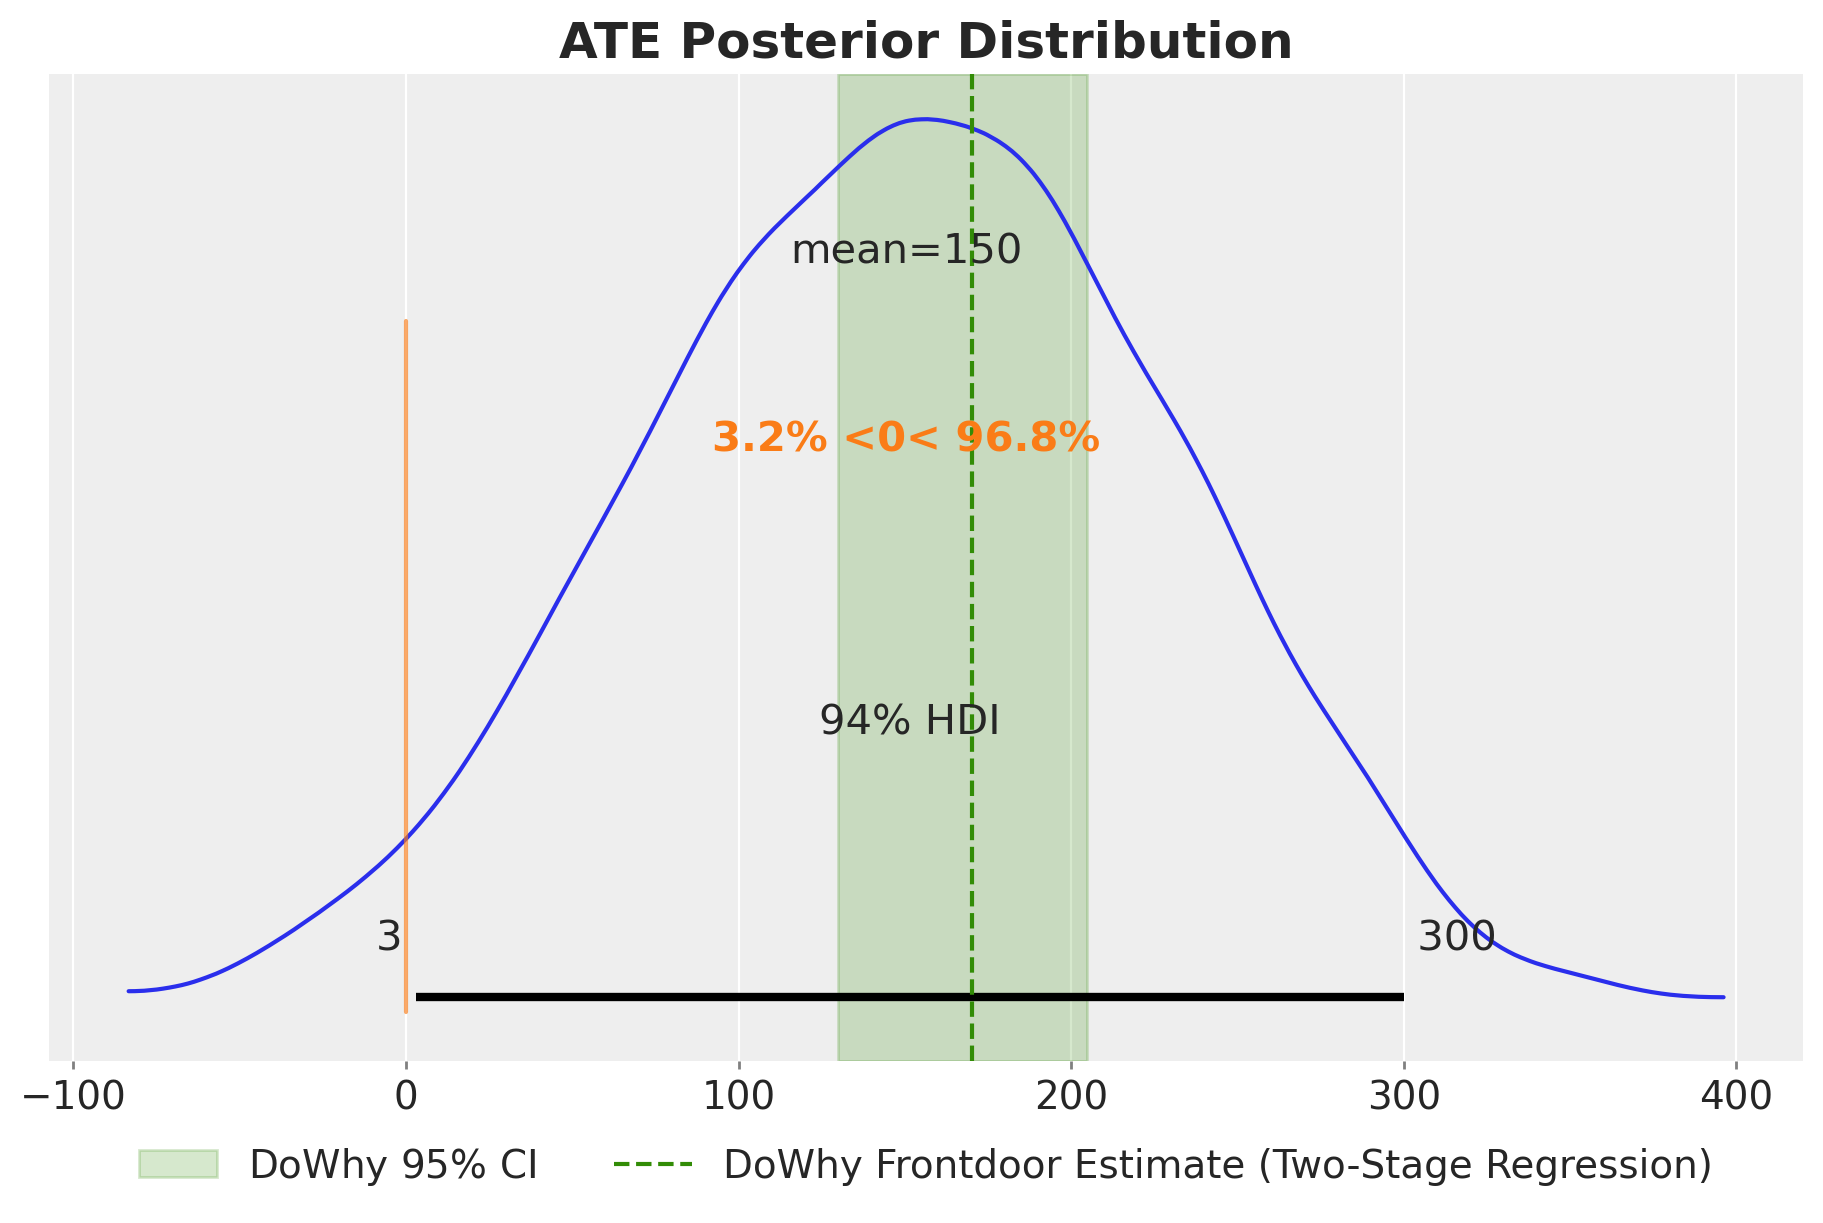

In [20]:
ate = (
    (
        do_1_idata["posterior_predictive"]["in_game_purchases"]
        - do_0_idata["posterior_predictive"]["in_game_purchases"]
    )
    .mean(dim="obs_idx")
    .rename("ate")
)


fig, ax = plt.subplots(figsize=(9, 6))
az.plot_posterior(ate, ref_val=0, ax=ax)
ax.axvspan(
    estimate_ci[0], estimate_ci[1], color="C2", alpha=0.2, label=r"DoWhy $95\%$ CI"
)
ax.axvline(
    estimate_value,
    color="C2",
    linestyle="--",
    label="DoWhy Frontdoor Estimate (Two-Stage Regression)",
)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=2)
ax.set_title("ATE Posterior Distribution", fontsize=18, fontweight="bold");